In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
from PIL import Image 
%matplotlib inline

In [2]:
font = cv2.FONT_HERSHEY_PLAIN
gender = ['M', 'F'] #M and F stadfor male and female
color = (0,255,255)
# load all the models and pickled files
data = np.load(open('./model/data_pca_dep_mean.pickle.npz','rb'))
hcc = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
svm  = pickle.load(open('./model/trained_svm.pickle','rb'))
updated_pca  = pickle.load(open('./model/updated_pca.pickle','rb'))

In [3]:
data.files
#'arr_2' contains the mean values

['arr_0', 'arr_1', 'arr_2']

In [4]:
mean = data['arr_2']
mean

array([0.37347449, 0.37027161, 0.36639958, ..., 0.37523855, 0.37596585,
       0.37792592])

In [5]:
def integrate(test, mode):
    if mode=='RGB':
        gray = cv2.cvtColor(test,cv2.COLOR_RGB2GRAY)
    else:
        gray = cv2.cvtColor(test,cv2.COLOR_BGR2GRAY)
    face = hcc.detectMultiScale(gray, 1.5, 3)
    for x,y,w,h in face:
        cropped_pic = gray[y:y+h, x:x+w]
        #applying min max scaling to make sure values are between 0 and 1
        #formula = (X - min(X))/max(X)
        #Can also be done using MinMaxScaler from sklearn.preprocessing
        
        #min(cropped_pic)=0 and max(cropped_pic)=255 
        cropped_pic = cropped_pic/255 
        
        if cropped_pic.shape[1] > 100:   #image is in the form of a square so
            #it is okay to consider the value at either 0'th or 1'st index 
            resized = cv2.resize(cropped_pic,(100,100),cv2.INTER_AREA)
        else:
            resized = cv2.resize(cropped_pic,(100,100),cv2.INTER_CUBIC)
        reshaped = resized.reshape(1,10000) 
        updated_mean = reshaped - mean #subtract mean value to do the normalize 
        #creating the eigen image
        eigen_image = updated_pca.transform(updated_mean)
        results = svm.predict_proba(eigen_image)[0] #obtaining the target vector with highest probability
        predict = results.argmax() #choosing 0(male) or 1(female) based on 
        confidence_interval = results[predict]
        #writing the results on the image 
        text = "%s : %0.2f"%(gender[predict],confidence_interval)
        cv2.putText(test,text,(x,y),font,1,color,2)
    return test
    
    

In [6]:
#selecting random images for testing purposes
test_img = Image.open('./data/male/male_000066.jpg')
test_img2 = Image.open('./data/female/female_000300.jpg')

In [7]:
mode1 = test_img.mode
print(mode1)

RGB


In [8]:
mode2 = test_img2.mode
print(mode2)

RGB


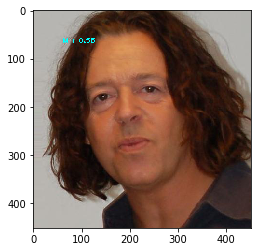

In [9]:
test_img_arr = np.array(test_img)
result=integrate(test_img_arr, mode1)
plt.imshow(result)

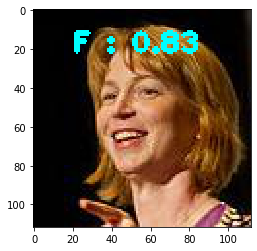

In [10]:
test_img_arr1 = np.array(test_img2)
result=integrate(test_img_arr1, mode2)
plt.imshow(result)